This script prepares the images for modeling, according to the Low birth weight criteria:
<br>    1. It uses the database csv file to filter by the criteria and to split patients into train, test and validation.
<br>    2. It crops the images according to the original mask and also according to the mask expanded by 1.3x.
<br>    3. The output is two datasets with cropped ultrasound images containing the placenta, each according to the original mask or the expanded mask. Each dataset counts with train, test and validation subsets. Each subset has a folder containing healthy and unhealthy images.x

In [1]:
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os

In [10]:
def sampleSize_buderer(SENS, SPEC, PREV, alpha, beta):
    """
    Sample size calculation using Buderer's method.
    
    Parameters:
    SENS (float): Target Sensitivity (in [0,1] range)
    SPEC (float): Target Specificity (in [0,1] range)
    PREV (float): Data prevalence (in [0,1] range)
    alpha (float): Maximum type I error (0.1 or 0.05)
    beta (float): Maximum type II error (in [0,1] range, typically 0.05 or 0.1)

    Returns:
    int: Power sampling size
    """
    
    if alpha == 0.05:
        Z = 1.96
    elif alpha == 0.1:
        Z = 1.64
    else:
        raise ValueError("alpha should be 0.05 or 0.1")
    
    N1 = Z**2 * SENS * (1 - SENS) / (beta**2 * PREV)
    N2 = Z**2 * SPEC * (1 - SPEC) / (beta**2 * (1 - PREV))

    N = max(N1, N2)
    
    return int(np.ceil(N))  # Round up to the nearest integer

# Example usage
N = sampleSize_buderer(0.50, 0.80, 0.16, 0.05, 0.20)
print(N)

151


# 1. Get positives and negatives

In [2]:
bbdd = pd.read_csv('../../../PLA_BBD.csv')
bbdd.head()

,Record ID,Origen étnico,Otra étnia,FECHA NACIMIENTO,FUR POR ECO,Edad materna,TPAL (sin guiones/puntos),Nuliparidad,Periodo intergenésico MENOR a 6 meses,Técnica de reproducción asistida (en gestación actual),...,"Hiperbilirrubinemia, µmol/l (nivel máximo) *250 µmol/L = 14.62 mg/dL *340 µmol/L = 19.88 mg/dL",Puntuación 22,Cultivo bacteriano,Puntuación 23,Hemorragia intraventricular,Puntuación 24,RCP durante el ingreso,Puntuación 25,Calculo MAIN (morbidity assessment index for newborns),Complete?.9
0,1,Europa,NaN,1988-08-10,2022-02-20,33,1041,No,No,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
1,2,Europa,NaN,1986-05-14,2022-02-22,35,1011,No,No,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
2,3,Europa,NaN,1997-10-26,2022-03-11,24,0,Yes,NaN,No,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
3,4,Sudasia,NaN,1980-10-22,2022-03-01,41,3003,No,No,No,...,Bilirrubina sérica >250/fototerapia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete
4,5,Europa,NaN,1980-05-17,2022-02-28,41,0,Yes,NaN,Yes,...,No hiperbilirrubinemia,NaN,Negativos/No realizados,NaN,No hemorragia intraventricular,NaN,No,0.0,0.0,Complete


In [3]:
bbdd = bbdd[['Record ID','Percentil peso nacimiento']]

In [4]:
bbdd['label_pos'] = bbdd.apply(lambda row: 1 if row['Percentil peso nacimiento'] < 10 else np.nan, axis=1)

In [5]:
bbdd['label_neg'] = bbdd.apply(lambda row: 0 if row['Percentil peso nacimiento'] >= 10 else np.nan, axis=1)

In [6]:
bbdd['label_pos'].value_counts()

label_pos
1.0    57
Name: count, dtype: int64

In [7]:
bbdd['label_neg'].value_counts()

label_neg
0.0    301
Name: count, dtype: int64

In [8]:
bbdd['label'] = np.where(bbdd['label_pos'].notna(), bbdd['label_pos'], np.where(bbdd['label_neg'].notna(), bbdd['label_neg'], np.nan))

In [9]:
bbdd['label'].value_counts()

label
0.0    301
1.0     57
Name: count, dtype: int64

In [11]:
bbdd = bbdd.dropna(subset=['label'])

In [12]:
bbdd['label'] = bbdd['label'].astype(int)

In [13]:
bbdd

,Record ID,Percentil peso nacimiento,label_pos,label_neg,label
0,1,55.0,NaN,0.0,0
1,2,67.0,NaN,0.0,0
2,3,62.0,NaN,0.0,0
3,4,100.0,NaN,0.0,0
4,5,32.0,NaN,0.0,0
...,...,...,...,...,...
360,361,17.0,NaN,0.0,0
361,362,71.0,NaN,0.0,0
362,363,99.0,NaN,0.0,0
363,364,68.0,NaN,0.0,0


# 2. Visualize what images and masks look like

In [21]:
def display_dicom_and_mask(dicom_file_path, mask_file_path):
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_file_path)

    # Get pixel data
    dicom_pixel_array = dicom_data.pixel_array

    # Read the mask file
    mask_pixel_array = plt.imread(mask_file_path)

    # Display the images side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(dicom_pixel_array, cmap=plt.cm.gray)
    axs[0].set_title('DICOM Image')

    axs[1].imshow(mask_pixel_array, cmap=plt.cm.gray)
    axs[1].set_title('Mask Image')

    plt.show()

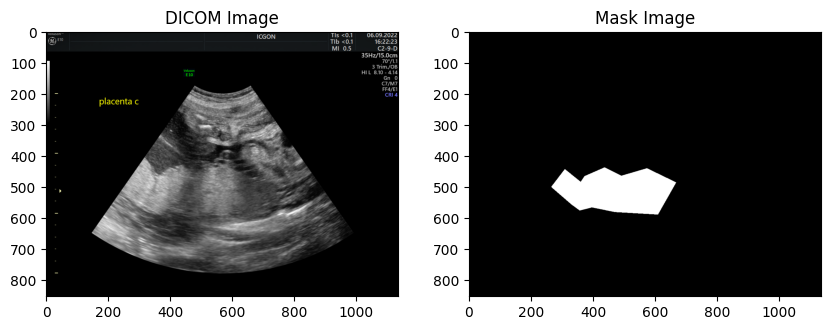

In [22]:
dicom_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-06-2_E CIR_PE 4_PLACENTA/20220906_162101/IMG_20220906_2_1.dcm'
mask_file_path = '../MASC/MASCARA PLACENTA 1-50/E75533-22-09-06-2_E CIR_PE 4_PLACENTA/20220906_162101/IMG_20220906_2_1_mask_P.png'
display_dicom_and_mask(dicom_file_path, mask_file_path)

# 3. Organize images

### 3.1. Put all images under the same directory and rename them

In [14]:
import os
import shutil
import re

pattern = r'PE (\d+)'

def copy_and_rename_files(root_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through each subfolder and copy/rename the files
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.dcm') or filename.endswith('.png'):
                try:
                    patient_number = re.search(pattern, foldername).group(1)
                    new_name = f"Patient_{patient_number}_{filename}"
                    #print(new_name)
                    source_path = os.path.join(foldername, filename)
                    destination_path = os.path.join(destination_folder, new_name)
                    shutil.copyfile(source_path, destination_path)
                except:
                    continue

In [16]:
copy_and_rename_files('../../MASC', '../../MASC_processed')

### 3.2. Check if there are masks for all images

In [18]:
def check_mask_pairs(folder_path):
    dcm_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]

    missing_pairs = []

    for dcm_file in dcm_files:
        base_name, _ = os.path.splitext(dcm_file)
        possible_mask_files = [f"{base_name}_mask_A.png", f"{base_name}_mask_P.png", f"{base_name}_mask.png"]

        found_pair = False

        for mask_file in possible_mask_files:
            if os.path.exists(os.path.join(folder_path, mask_file)):
                found_pair = True
                break

        if not found_pair:
            missing_pairs.append(dcm_file)

    return missing_pairs

In [19]:
missing_pairs = check_mask_pairs('../../MASC_processed')
print('Total images without a mask:', len(missing_pairs))

Total images without a mask: 493


### 3.3. Look for duplicates

In [20]:
from collections import Counter
# find if there are duplicated masks named differently (A vs P)
def find_duplicate_masks(folder_path):
    mask_files = [f for f in os.listdir(folder_path) if f.endswith('_mask_A.png') or f.endswith('_mask_P.png')]

    # Remove 'A' and 'P' suffixes to identify duplicates
    base_names = [os.path.splitext(file)[0].rsplit('_mask_', 1)[0] for file in mask_files]

    # Count occurrences of each base name
    base_name_counts = Counter(base_names)

    # Filter base names with more than one occurrence
    duplicates = {key: count for key, count in base_name_counts.items() if count > 1}

    return duplicates

In [21]:
find_duplicate_masks('../../MASC_processed')

{}

### 3.4. Give uniform names to masks

In [22]:
# since there are no duplicates, we can rename all masks to _mask instead of _mask_A or _mask_P
def rename_mask_files(root_folder):
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('_mask_A.png') or filename.endswith('_mask_P.png'):
                original_path = os.path.join(foldername, filename)
                new_filename = filename.replace('_mask_A.png', '_mask.png').replace('_mask_P.png', '_mask.png')
                new_path = os.path.join(foldername, new_filename)
                os.rename(original_path, new_path)

In [23]:
rename_mask_files('../../MASC_processed')

In [24]:
for foldername, subfolders, filenames in os.walk('../../MASC_processed'):
    for filename in filenames:
        if 'mask' in filename:
            file_path = os.path.join(foldername, filename)
            print(file_path)

../../MASC_processed/Patient_285_IMG_20230417_1_4_mask.png
../../MASC_processed/Patient_256_IMG_20230328_1_3_mask.png
../../MASC_processed/Patient_256_IMG_20230328_1_2_mask.png
../../MASC_processed/Patient_59_IMG_20221019_1_1_mask.png
../../MASC_processed/Patient_199_IMG_20230220_1_4_mask.png
../../MASC_processed/Patient_409_IMG_20230719_1_4_mask.png
../../MASC_processed/Patient_403_IMG_20230718_1_3_mask.png
../../MASC_processed/Patient_403_IMG_20230718_1_2_mask.png
../../MASC_processed/Patient_330_IMG_20230511_1_4_mask.png
../../MASC_processed/Patient_208_IMG_20230228_1_3_mask.png
../../MASC_processed/Patient_262_IMG_20230329_1_2_mask.png
../../MASC_processed/Patient_208_IMG_20230228_1_2_mask.png
../../MASC_processed/Patient_262_IMG_20230329_1_3_mask.png
../../MASC_processed/Patient_89_IMG_20221109_1_3_mask.png
../../MASC_processed/Patient_421_IMG_20230802_1_3_mask.png
../../MASC_processed/Patient_217_IMG_20230301_1_2_mask.png
../../MASC_processed/Patient_276_IMG_20230411_2_1_mask.png

### 3.5. Delete images that do not have a mask

In [25]:
# get rid of images that do not have a mask
def delete_images(directory, image_names):
    for filename in image_names:
        file_path = os.path.join(directory, filename)
        try:
            os.remove(file_path)
            print(f"Deleted: {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except Exception as e:
            print(f"Error deleting {filename}: {e}")

missing_pairs = check_mask_pairs('../../MASC_processed')
delete_images('../../MASC_processed', missing_pairs)

Deleted: Patient_448_IMG_20230904_1_1.dcm
Deleted: Patient_101_IMG_20221122_1_2.dcm
Deleted: Patient_395_IMG_20230712_1_1.dcm
Deleted: Patient_50_IMG_20221011_1_1.dcm
Deleted: Patient_120_IMG_20221212_1_2.dcm
Deleted: Patient_47_IMG_20221010_1_1.dcm
Deleted: Patient_45_IMG_20221006_1_1.dcm
Deleted: Patient_117_IMG_20221130_1_2.dcm
Deleted: Patient_414_IMG_20230724_2_1.dcm
Deleted: Patient_65_IMG_20221020_1_4.dcm
Deleted: Patient_70_IMG_20221026_1_1.dcm
Deleted: Patient_128_IMG_20221214_1_1.dcm
Deleted: Patient_96_IMG_20221117_2_2.dcm
Deleted: Patient_350_IMG_20230529_1_1.dcm
Deleted: Patient_409_IMG_20230719_1_1.dcm
Deleted: Patient_388_IMG_20230710_2_1.dcm
Deleted: Patient_312_IMG_20230503_1_1.dcm
Deleted: Patient_83_IMG_20221103_1_1.dcm
Deleted: Patient_127_IMG_20221214_1_2.dcm
Deleted: Patient_319_IMG_20230509_1_1.dcm
Deleted: Patient_65_IMG_20221020_1_5.dcm
Deleted: Patient_112_IMG_20221129_1_1.dcm
Deleted: Patient_248_IMG_20230322_1_1.dcm
Deleted: Patient_203_IMG_20230221_1_1.dcm


# 4. Split into train, validation and test sets

### 4.1. Get list of images with patient id, to join with file bbdd that contains labels

In [26]:
import csv
import os

def create_csv_with_dcm_names(directory, output_csv):
    dcm_files = [filename for filename in os.listdir(directory) if filename.endswith('.dcm')]

    with open(output_csv, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['image_name'])
        for dcm_file in dcm_files:
            csv_writer.writerow([dcm_file])

create_csv_with_dcm_names('../../MASC_processed', 'images_list.csv')

In [27]:
data = pd.read_csv('images_list.csv')
data.head()

,image_name
0,Patient_315_IMG_20230504_1_4.dcm
1,Patient_147_IMG_20221228_1_5.dcm
2,Patient_372_IMG_20230615_1_2.dcm
3,Patient_20_IMG_20220922_1_3.dcm
4,Patient_23_IMG_20220927_1_3.dcm


In [28]:
import re
def extract_patient_number(filename):
    match = re.search(r'Patient_(\d+)', filename)
    patient_number = match.group(1)
    return patient_number

In [29]:
data['Patient_ID'] = data['image_name'].apply(extract_patient_number)

In [30]:
data

,image_name,Patient_ID
0,Patient_315_IMG_20230504_1_4.dcm,315
1,Patient_147_IMG_20221228_1_5.dcm,147
2,Patient_372_IMG_20230615_1_2.dcm,372
3,Patient_20_IMG_20220922_1_3.dcm,20
4,Patient_23_IMG_20220927_1_3.dcm,23
...,...,...
1332,Patient_229_IMG_20230309_1_3.dcm,229
1333,Patient_386_IMG_20230621_1_4.dcm,386
1334,Patient_356_IMG_20230530_1_3.dcm,356
1335,Patient_418_IMG_20230726_1_4.dcm,418


In [31]:
bbdd['Record ID'] = bbdd['Record ID'].astype(int)
data['Patient_ID'] = data['Patient_ID'].astype(int)

In [32]:
labeled_data = data.merge(bbdd[['Record ID', 'label']], left_on='Patient_ID', right_on='Record ID', how='left')
labeled_data

,image_name,Patient_ID,Record ID,label
0,Patient_315_IMG_20230504_1_4.dcm,315,315.0,0.0
1,Patient_147_IMG_20221228_1_5.dcm,147,147.0,1.0
2,Patient_372_IMG_20230615_1_2.dcm,372,NaN,NaN
3,Patient_20_IMG_20220922_1_3.dcm,20,20.0,0.0
4,Patient_23_IMG_20220927_1_3.dcm,23,23.0,0.0
...,...,...,...,...
1332,Patient_229_IMG_20230309_1_3.dcm,229,229.0,0.0
1333,Patient_386_IMG_20230621_1_4.dcm,386,NaN,NaN
1334,Patient_356_IMG_20230530_1_3.dcm,356,356.0,1.0
1335,Patient_418_IMG_20230726_1_4.dcm,418,NaN,NaN


In [33]:
labeled_data = labeled_data.dropna(subset=['label'])
labeled_data['label'] = labeled_data['label'].astype(int)

/var/folders/3k/psrvdwgn6vx30p4mwv7m6gfw0000gs/T/ipykernel_35903/4010842100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['label'] = labeled_data['label'].astype(int)


In [34]:
labeled_data['label'].value_counts()

label
0    890
1    171
Name: count, dtype: int64

In [35]:
import numpy as np
import pandas as pd
import random

# Set seed for reproducibility
random.seed(42)
# Function to split patients while maintaining label proportion
def stratified_split(data, num_test, num_val):
    # Get the proportion of labels
    label_proportions = data['label'].value_counts(normalize=True)
    test_patients = []
    val_patients = []
    train_patients = []
    for label, proportion in label_proportions.items():
        label_data = data[data['label'] == label]
        unique_patients = label_data['Patient_ID'].unique()
        random.shuffle(unique_patients)
        num_label_test = int(np.round(num_test * proportion))
        num_label_val = int(np.round(num_val * proportion))
        test_patients_label = unique_patients[:num_label_test]
        val_patients_label = unique_patients[num_label_test:num_label_test + num_label_val]
        train_patients_label = unique_patients[num_label_test + num_label_val:]
        test_patients.extend(test_patients_label)
        val_patients.extend(val_patients_label)
        train_patients.extend(train_patients_label)
    return train_patients, val_patients, test_patients
# Define the number of patients in test and validation sets
num_test_patients = 151
num_val_patients = 30
train_patients, val_patients, test_patients = stratified_split(labeled_data, num_test_patients, num_val_patients)
# Filter the original dataset to create the datasets
train_data = labeled_data[labeled_data['Patient_ID'].isin(train_patients)]
validation_data = labeled_data[labeled_data['Patient_ID'].isin(val_patients)]
test_data = labeled_data[labeled_data['Patient_ID'].isin(test_patients)]

In [36]:
# check that no patient is in more than one dataset
train_patients = set(train_data['Patient_ID'])
val_patients = set(validation_data['Patient_ID'])
test_patients = set(test_data['Patient_ID'])

if (
    train_patients.intersection(val_patients) or
    train_patients.intersection(test_patients) or
    val_patients.intersection(test_patients)
):
    print('Repeated values')
else:
    print('No repeated values')

No repeated values


In [37]:
train_data['label'].value_counts()

label
0    434
1     84
Name: count, dtype: int64

In [38]:
validation_data['label'].value_counts()

label
0    75
1    15
Name: count, dtype: int64

In [39]:
test_data['label'].value_counts()

label
0    381
1     72
Name: count, dtype: int64

In [40]:
train_data

,image_name,Patient_ID,Record ID,label
5,Patient_217_IMG_20230301_1_4.dcm,217,217.0,0
6,Patient_55_IMG_20221018_1_3.dcm,55,55.0,1
11,Patient_33_IMG_20220929_1_1.dcm,33,33.0,0
15,Patient_150_IMG_20221229_1_5.dcm,150,150.0,0
18,Patient_232_IMG_20230309_1_4.dcm,232,232.0,0
...,...,...,...,...
1329,Patient_180_IMG_20230124_1_3.dcm,180,180.0,0
1331,Patient_165_IMG_20230111_1_4.dcm,165,165.0,1
1332,Patient_229_IMG_20230309_1_3.dcm,229,229.0,0
1334,Patient_356_IMG_20230530_1_3.dcm,356,356.0,1


### 4.2. Distribute images into different set folders

In [41]:
output_dir_0 = "../../Data/train/unhealthy"
output_dir_0b = "../../Data/train/healthy"
output_dir_1 = "../../Data/validation/unhealthy"
output_dir_1b = "../../Data/validation/healthy"
output_dir_2 = "../../Data/test/unhealthy"
output_dir_2b = "../../Data/test/healthy"

os.makedirs(output_dir_0, exist_ok=True)
os.makedirs(output_dir_0b, exist_ok=True)
os.makedirs(output_dir_1, exist_ok=True)
os.makedirs(output_dir_1b, exist_ok=True)
os.makedirs(output_dir_2, exist_ok=True)
os.makedirs(output_dir_2b, exist_ok=True)

In [42]:
import shutil

datasets = {
    "train": train_data,
    "validation": validation_data,
    "test": test_data
}

for name, data in datasets.items():
    variable_name = name
    for index, row in data.iterrows():
        output_dir_unhealthy = "../../Data/" + variable_name.split('_')[0] + '/unhealthy'
        output_dir_healthy = "../../Data/" + variable_name.split('_')[0] + '/healthy'
        
        image_filename = row['image_name'] #+ '.png' # Replace with your column name
        label = row['label']  
        # Decide the output directory based on the label
        if label == 0:
            output_directory = output_dir_healthy
        elif label == 1:
            output_directory = output_dir_unhealthy
        else:
            continue  # Skip images with invalid labels

        # Copy the image to the corresponding directory
        image_source_path = "../../MASC_processed/" + image_filename 
        image_destination_path = os.path.join(output_directory, image_filename)
        shutil.copy(image_source_path, image_destination_path)

In [43]:
# add masks to respective folders
for name, data in datasets.items():
    variable_name = name
    for index, row in data.iterrows():
        output_dir_unhealthy = "../../Data/" + variable_name.split('_')[0] + '/unhealthy'
        output_dir_healthy = "../../Data/" + variable_name.split('_')[0] + '/healthy'
        
        image_filename = row['image_name'][:-4] + '_mask.png' # Replace with your column name
        label = row['label']  # Replace with your column name

        # Decide the output directory based on the label
        if label == 0:
            output_directory = output_dir_healthy
        elif label == 1:
            output_directory = output_dir_unhealthy
        else:
            continue  # Skip images with invalid labels

        # Copy the image to the corresponding directory
        image_source_path = "../../MASC_processed/" + image_filename 
        image_destination_path = os.path.join(output_directory, image_filename)
        shutil.copy(image_source_path, image_destination_path)

# 5. Crop images based on mask

In [44]:
def extract_bounding_box(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contours[0])
        return x, y, w, h
    else:
        # No contours found, return default values or handle appropriately
        return 0, 0, 0, 0

In [45]:
import cv2

def crop_image(image_path, bounding_box, output_path):
    # Read the image
    img = pydicom.dcmread(image_path).pixel_array

    # Extract coordinates from the bounding box
    x, y, w, h = bounding_box

    # Crop the image using the bounding box
    cropped_img = img[y:y+h, x:x+w]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_img)

In [46]:
# crop image that expands the mask
import pydicom
import cv2

def crop_image(image_path, bounding_box, output_path, expand_factor=1.2):
    """
    Crop an image using an expanded bounding box and save the cropped image.

    Parameters:
    image_path (str): Path to the DICOM image.
    bounding_box (tuple): A tuple (x, y, w, h) representing the original bounding box.
    output_path (str): Path to save the cropped image.
    expand_factor (float, optional): Factor by which to expand the bounding box.
    """
    # Read the image
    img = pydicom.dcmread(image_path).pixel_array

    # Extract coordinates from the bounding box
    x, y, w, h = bounding_box

    # Calculate new bounding box dimensions
    new_w = int(w * expand_factor)
    new_h = int(h * expand_factor)
    new_x = max(x - (new_w - w) // 2, 0)
    new_y = max(y - (new_h - h) // 2, 0)

    # Adjust the coordinates to ensure they don't go beyond the image boundaries
    new_x = min(new_x, img.shape[1] - new_w)
    new_y = min(new_y, img.shape[0] - new_h)

    # Crop the image using the expanded bounding box
    cropped_img = img[new_y:new_y+new_h, new_x:new_x+new_w]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_img)

In [47]:
def crop_images(directory, expand_factor):
    for filename in os.listdir(directory):
        if filename.endswith('.dcm'):
            # find mask
            mask_filename = filename[:-4] + '_mask.png'
            mask_filename_path = directory + mask_filename

            mask = cv2.imread(mask_filename_path, cv2.IMREAD_GRAYSCALE)

            x, y, w, h = extract_bounding_box(mask)

            image_path = directory + filename
            bounding_box = (x, y, w, h)  # Replace with actual coordinates
            if expand_factor == 1:
                output_dir = (directory.replace('train', 'cropped_train')
                                        .replace('validation', 'cropped_validation')
                                        .replace('test', 'cropped_test'))
            else:
                output_dir = (directory.replace('train', 'cropped_expanded_train')
                                        .replace('validation', 'cropped_expanded_validation')
                                        .replace('test', 'cropped_expanded_test'))

            os.makedirs(output_dir, exist_ok=True)
            output_path = output_dir + filename[:-4] + '.png'

            crop_image(image_path, bounding_box, output_path, expand_factor=expand_factor)


### 5.1. Crop with mask size

In [48]:
crop_images('../../Data/train/unhealthy/', expand_factor=1)
crop_images('../../Data/train/healthy/', expand_factor=1)
crop_images('../../Data/test/unhealthy/', expand_factor=1)
crop_images('../../Data/test/healthy/', expand_factor=1)
crop_images('../../Data/validation/unhealthy/', expand_factor=1)
crop_images('../../Data/validation/healthy/', expand_factor=1)

### 5.2. Crop with extended mask

In [49]:
crop_images('../../Data/train/unhealthy/', expand_factor=1.3)
crop_images('../../Data/train/healthy/', expand_factor=1.3)
crop_images('../../Data/test/unhealthy/', expand_factor=1.3)
crop_images('../../Data/test/healthy/', expand_factor=1.3)
crop_images('../../Data/validation/unhealthy/', expand_factor=1.3)
crop_images('../../Data/validation/healthy/', expand_factor=1.3)

# 6. Checking before and after cropping

In [109]:
def display_dicom_and_mask(dicom_file_path):
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_file_path)

    # Get pixel data
    dicom_pixel_array = dicom_data.pixel_array

    # Read the mask file
    mask_file_path = dicom_file_path[:-4] + '_mask.png'
    mask_pixel_array = plt.imread(mask_file_path)
    
    # Read the cropped image
    if 'train' in dicom_file_path:
        cropped_file_path = '../Data/cropped_train' + dicom_file_path[13:-4] + '.png'
    if 'validation' in dicom_file_path:
        cropped_file_path = '../Data/cropped_validation' + dicom_file_path[18:-4] + '.png'
    if 'test' in dicom_file_path:
        cropped_file_path = '../Data/cropped_test' + dicom_file_path[12:-4] + '.png'
    cropped_pixel_array = plt.imread(cropped_file_path)

    # Display the images side by side
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(dicom_pixel_array, cmap=plt.cm.gray)
    axs[0].set_title('DICOM Image')

    axs[1].imshow(mask_pixel_array, cmap=plt.cm.gray)
    axs[1].set_title('Mask Image')
    
    axs[2].imshow(cropped_pixel_array, cmap=plt.cm.gray)
    axs[2].set_title('Cropped Image')

    plt.show()

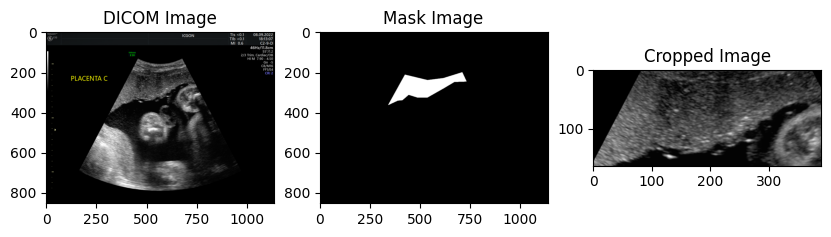

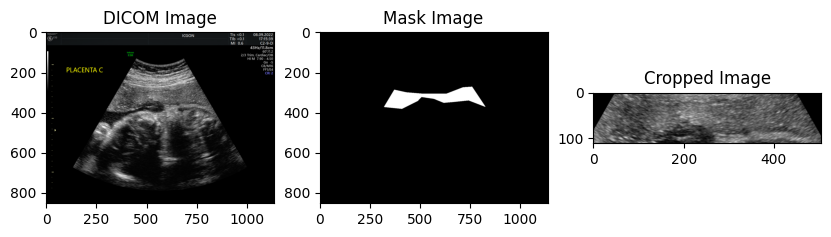

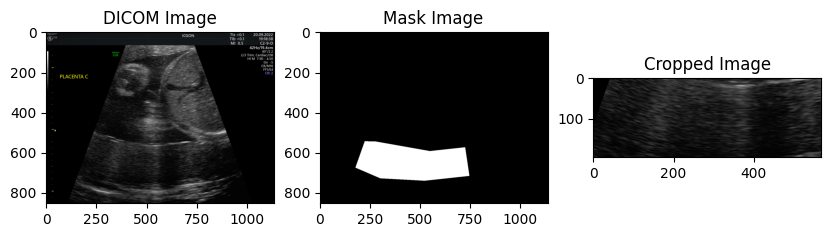

In [110]:
display_dicom_and_mask('../Data/train/healthy/Patient_2_IMG_20220908_2_1.dcm')
display_dicom_and_mask('../Data/validation/healthy/Patient_8_IMG_20220908_6_1.dcm')
display_dicom_and_mask('../Data/test/healthy/Patient_3_IMG_20220920_1_1.dcm')

# 7. Counts

In [50]:
def count_dcm_files(directory_path):
    dcm_files = [filename for filename in os.listdir(directory_path) if filename.endswith('.dcm')]
    num_dcm_files = len(dcm_files)
    return num_dcm_files

def count_png_files(directory_path):
    png_files = [filename for filename in os.listdir(directory_path) if filename.endswith('.png')]
    num_png_files = len(png_files)
    return num_png_files


directory_path = '../../Data/cropped_train/healthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

directory_path = '../../Data/cropped_train/unhealthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

directory_path = '../../Data/cropped_validation/healthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

directory_path = '../../Data/cropped_validation/unhealthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

directory_path = '../../Data/cropped_test/healthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

directory_path = '../../Data/cropped_test/unhealthy'
num_dcm_files = count_png_files(directory_path)
print(f'The number of .dcm files in the directory {directory_path} is: {num_dcm_files}')

The number of .dcm files in the directory ../../Data/cropped_train/healthy is: 434
The number of .dcm files in the directory ../../Data/cropped_train/unhealthy is: 84
The number of .dcm files in the directory ../../Data/cropped_validation/healthy is: 75
The number of .dcm files in the directory ../../Data/cropped_validation/unhealthy is: 15
The number of .dcm files in the directory ../../Data/cropped_test/healthy is: 381
The number of .dcm files in the directory ../../Data/cropped_test/unhealthy is: 72


In [51]:
train_data['label'].value_counts()

label
0    434
1     84
Name: count, dtype: int64

In [52]:
validation_data['label'].value_counts()

label
0    75
1    15
Name: count, dtype: int64

In [53]:
test_data['label'].value_counts()

label
0    381
1     72
Name: count, dtype: int64

In [54]:
print('Unique patients in train:', train_data['Patient_ID'].nunique())

Unique patients in train: 172


In [55]:
print('Unique patients in validation:', validation_data['Patient_ID'].nunique())

Unique patients in validation: 30


In [56]:
print('Unique patients in test:', test_data['Patient_ID'].nunique())

Unique patients in test: 151


In [57]:
# total healthy patients and patients affected in full dataset
patients_labeled = labeled_data[['Patient_ID', 'label']].drop_duplicates()
patients_labeled['label'].value_counts()

label
0    296
1     57
Name: count, dtype: int64

In [58]:
# total healthy patients and patients affected in train
train_labeled = train_data[['Patient_ID', 'label']].drop_duplicates()
train_labeled['label'].value_counts()

label
0    144
1     28
Name: count, dtype: int64

In [59]:
# total healthy patients and patients affected in validation
val_labeled = validation_data[['Patient_ID', 'label']].drop_duplicates()
val_labeled['label'].value_counts()

label
0    25
1     5
Name: count, dtype: int64

In [60]:
# total healthy patients and patients affected in test
test_labeled = test_data[['Patient_ID', 'label']].drop_duplicates()
test_labeled['label'].value_counts()

label
0    127
1     24
Name: count, dtype: int64